In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torchtext.data import Field

import os
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from itertools import groupby
from jiwer import wer

from models.config import INPUT_SIZE
from dataset import PhoenixDataset
from models.anchors import generate_default_anchor_maps

## Load Phoenix dataset

In [2]:
BSZ = 2
root = '/mnt/data/public/datasets'

transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE, Image.BILINEAR), 
    transforms.CenterCrop(INPUT_SIZE), transforms.ToTensor()])

TRG = Field(sequential=True, use_vocab=True,
            init_token=None, eos_token=None,
            lower=True, tokenize='spacy',
            tokenizer_language='de')

csv_path = os.path.join(root, 'phoenix2014-release/phoenix-2014-multisigner')
csv_path = os.path.join(csv_path, 'annotations/manual/train.corpus.csv')
csv_file = pd.read_csv(csv_path)
train_sents = [csv_file.iloc[i, 0].lower().split('|')[3].split()
               for i in range(len(csv_file))]
TRG.build_vocab(train_sents, min_freq=1)
VocabSize = len(TRG.vocab)


def my_collate(batch):
    videos = [item['video'] for item in batch]
    videos = pad_sequence(videos, batch_first=True)
    annotations = [item['annotation'].split() for item in batch]
    annotations = TRG.process(annotations)
    return {'videos': videos, 'annotations': annotations}


# train_loader = DataLoader(
#     PhoenixDataset(root, 'train', transform),
#     batch_size=BSZ, num_workers=BSZ, pin_memory=True,
#     shuffle=True, collate_fn=my_collate)

dev_loader = DataLoader(
    PhoenixDataset(root, 'dev', transform),
    batch_size=1, num_workers=1, pin_memory=False,
    shuffle=False, collate_fn=my_collate)

test_loader = DataLoader(
    PhoenixDataset(root, 'test', transform),
    batch_size=1, num_workers=1, pin_memory=True,
    shuffle=False, collate_fn=my_collate)

## Visualize weakly fine-grained bbx

/home/xieliang/anaconda3/envs/sign/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.fine_grained_cnn.attention_net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


blank idx: 1233 | unk idx: 0
annotation: 4 6 69 8 29 18 139 3
prediction: 4 6 69 8 122 18 34 3
wer: 0.25


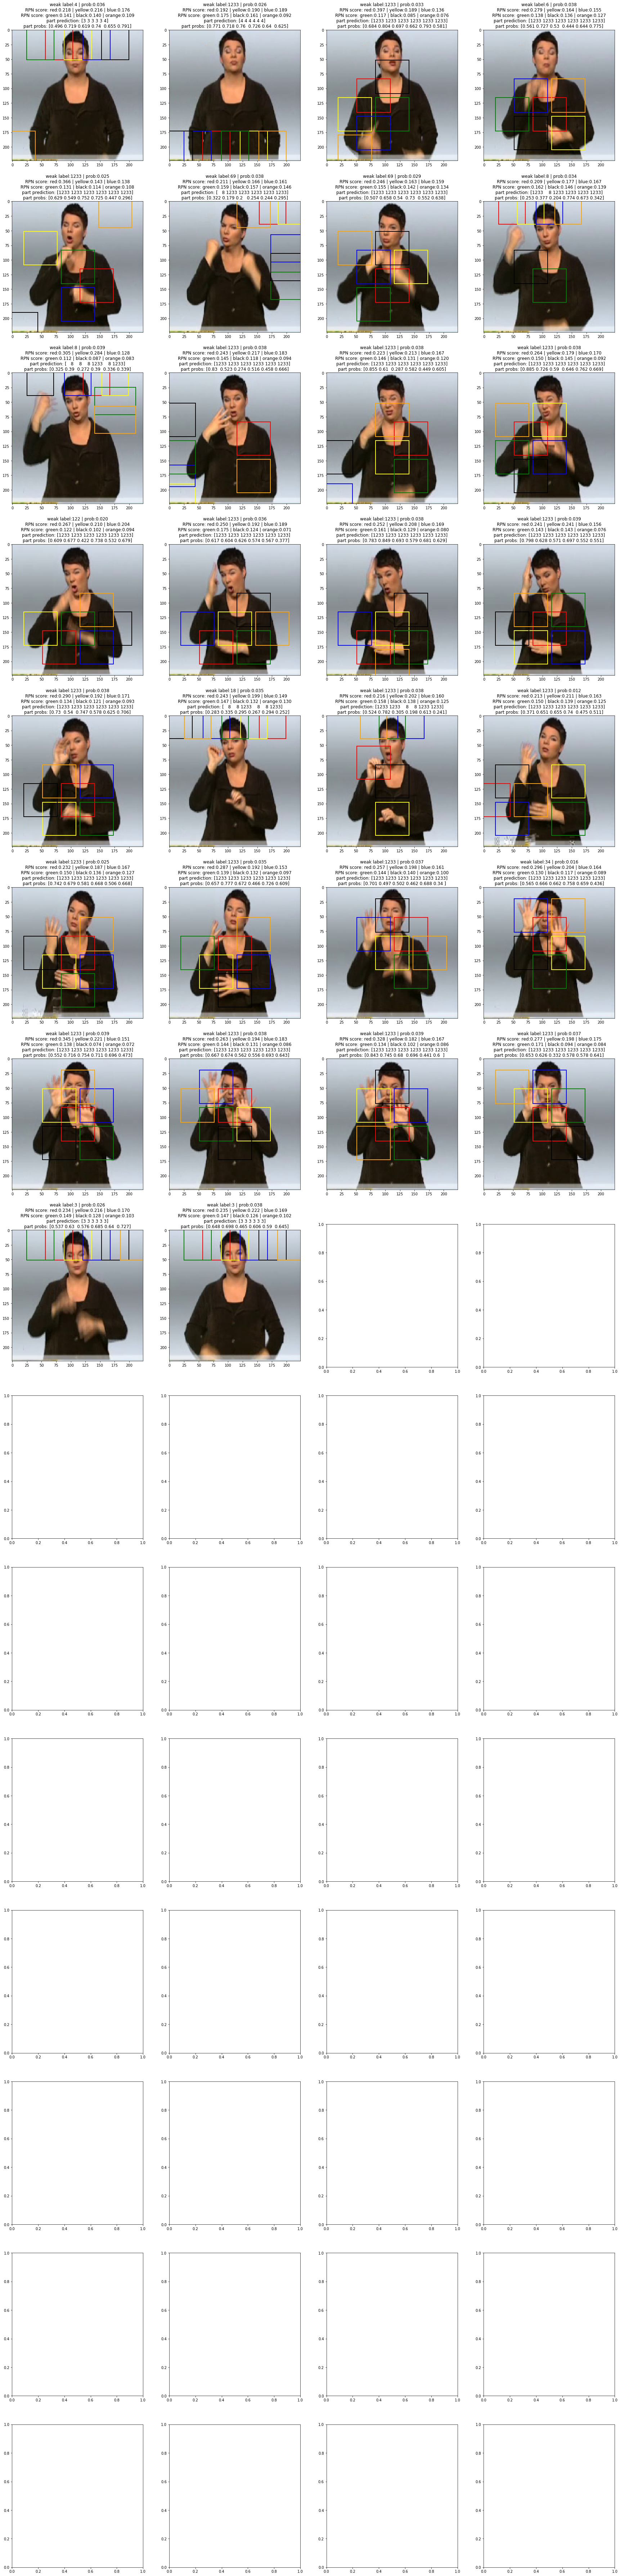

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# device = torch.device('cpu')

save_dict1 = torch.load(
    '/home/xieliang/Data/sign-language-recognition/save/CNN_RNN_CTC.pth')
cnn_rnn_ctc_net = save_dict1['net'].cuda()
for parmas in cnn_rnn_ctc_net.parameters():
    parmas.requires_grad = False

save_root = '/home/xieliang/Data/sign-language-recognition'
save_model = os.path.join(save_root, 'save/fine_grained_cnn5.pth')

save_dict_test = torch.load(save_model)
fine_grained_cnn_net = save_dict_test['net'].cuda()

# [412, 4]
_, edge_anchors, _ = generate_default_anchor_maps()


with torch.no_grad():
    for batch_idx, batch in enumerate(dev_loader):

        if batch_idx == 12:
            print('blank idx:', len(TRG.vocab), '| unk idx:', TRG.vocab.stoi['<unk>'])
            inputs = batch['videos'].cuda()
            gt = ' '.join([str(i) for i in batch['annotations'].view(-1).numpy()])
            print('annotation:', gt)

            n, t, c, h, w = inputs.size()
            targets = cnn_rnn_ctc_net(inputs)
            probs, targets = targets.permute(1, 0, 2).contiguous().view(n*t, -1).max(-1)
            targets = targets.cpu().detach().numpy()
            prediction = ' '.join([str(k) for k, _ in groupby(targets) if k != VocabSize])
            print('prediction:', prediction)
            print('wer:', wer(gt, prediction, standardize=True))
            probs = F.softmax(probs, dim=0)

            inputs = inputs.view(-1, c, h, w)
            raw_logits, concat_logits, part_logits, top_n_index, top_n_prob, concat_out = fine_grained_cnn_net(
                inputs)
            # [n*t, topN]
            top_n_index = top_n_index.cpu().detach().numpy()
            # [n*t, topN]
            top_n_prob = F.softmax(top_n_prob, dim=1)
            # part_logits: [n*t*topN, class]
            
            part_probs, part_labels = F.softmax(part_logits, dim=1).max(-1)
            part_probs = np.around(part_probs.view(t,-1).cpu().detach().numpy(), decimals=3)
            part_labels = part_labels.view(t,-1).cpu().detach().numpy()
            inputs = batch['videos'].detach().cpu().numpy()[0].transpose(0, 2, 3, 1)
            

            fig, ax = plt.subplots(15, 4, figsize=(30, 130))
            for i in range(t):
                r = i // 4
                c = i % 4
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 0]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='red', fill=False, linewidth=2))
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 1]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='yellow', fill=False, linewidth=2))
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 2]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='blue', fill=False, linewidth=2))
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 3]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='green', fill=False, linewidth=2))
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 4]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='black', fill=False, linewidth=2))
                y0, x0, y1, x1 = edge_anchors[top_n_index[i, 5]]
                ax[r][c].add_patch(plt.Rectangle(
                    (x0, y0), x1-x0, y1-y0, edgecolor='orange', fill=False, linewidth=2))
                ax[r][c].imshow(inputs[i])
                
                line1 = f'weak label:{targets[i]} | prob:{probs[i]:.3f}'
                line2 = f'RPN score: red:{top_n_prob[i][0]:.3f} | yellow:{top_n_prob[i][1]:.3f} | blue:{top_n_prob[i][2]:.3f}'
                line3 = f'RPN score: green:{top_n_prob[i][3]:.3f} | black:{top_n_prob[i][4]:.3f} | orange:{top_n_prob[i][5]:.3f}'
                line4 = f'part prediction: {part_labels[i]}'
                line5 = f'part probs: {part_probs[i]}'
                ax[r][c].set_title(line1+'\n'+line2+'\n'+line3+'\n'+line4+'\n'+line5)
                
            plt.show()

            break

In [4]:
# def wer_test(r, h):
#     # initialisation
#     d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
#     d = d.reshape((len(r)+1, len(h)+1))
#     for i in range(len(r)+1):
#         for j in range(len(h)+1):
#             if i == 0:
#                 d[0][j] = j
#             elif j == 0:
#                 d[i][0] = i

#     # computation
#     for i in range(1, len(r)+1):
#         for j in range(1, len(h)+1):
#             if r[i-1] == h[j-1]:
#                 d[i][j] = d[i-1][j-1]
#             else:
#                 substitution = d[i-1][j-1] + 1
#                 insertion = d[i][j-1] + 1
#                 deletion = d[i-1][j] + 1
#                 d[i][j] = min(substitution, insertion, deletion)

#     return float(d[len(r)][len(h)]) / len(r) * 100


# targets = [271, 318, 12, 20, 22, 7, 22, 64, 7, 45, 28, 743, 48, 794, 60, 509, 7, 60, 8]
# prediction = [1233, 318, 1233, 40, 1233, 22, 1233, 7, 1233, 22, 69, 1233, 8, 1233, 45, 1233, 387, 1233, 5, 1233, 60, 1233, 7, 1233, 60, 8, 1233]
# print(wer_test(targets, prediction))


94.73684210526315


## Visualize ctc predictions

In [ ]:
# def cal_wer(targets, outs):
#     pass

# save_dict_test = torch.load(save_model)
# start_epoch = save_dict_test['epoch']+1
# best_dev_wer = save_dict_test['best_dev_wer']
# net = save_dict_test['net'].cuda()

# with torch.no_grad():
#     for batch_idx, batch in enumerate(val_loader):
#         inputs = batch['videos'].cuda()
#         targets = batch['annotations'].permute(1,0).contiguous().cuda()
#         input_lens = batch['video_lens'].cuda()
#         target_lens = batch['annotation_lens'].cuda()

#         outs = net(inputs)
#         loss = criterion(outs, targets, input_lens, target_lens)

#         outs = outs.max(-1)[1].permute(1,0).contiguous().view(-1)
#         outs = ' '.join([TRG.vocab.itos[k] for k, _ in groupby(outs) if k != VocabSize])
#         targets = targets.view(-1)
#         targets = ' '.join([TRG.vocab.itos[k] for k in targets])
#         epoch_wer += cal_wer(targets, outs, standardize=True)
#         epoch_loss += loss.item()
        
#     epoch_wer /= len(val_loader)
#     epoch_loss /= len(val_loader)
#     print(epoch_wer)
#     print(epoch_loss)